In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn as sb
import os
sns.set()
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import pathlib
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import IsolationForest
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OneHotEncoder

In [45]:
for dirname, _, filenames in os.walk('input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session
train_df = pd.read_csv('input/train.csv')
test_df = pd.read_csv('input/test.csv')
len(test_df)

input\sample_submission.csv
input\test.csv
input\train.csv


4277

### Data Description

In [46]:
train_df.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


In [47]:
train_df.dtypes

PassengerId      object
HomePlanet       object
CryoSleep        object
Cabin            object
Destination      object
Age             float64
VIP              object
RoomService     float64
FoodCourt       float64
ShoppingMall    float64
Spa             float64
VRDeck          float64
Name             object
Transported        bool
dtype: object

In [48]:
train_df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [49]:
def get_categorical_variables(df):
    return df.select_dtypes(include=['object']).columns

def get_numerical_variables(df):
    return df._get_numeric_data().columns

In [50]:
c_var=get_categorical_variables(train_df)
for col in c_var:
    print(col)

PassengerId
HomePlanet
CryoSleep
Cabin
Destination
VIP
Name


In [51]:
n_var=get_numerical_variables(train_df)
for col in n_var:
    print(col)

Age
RoomService
FoodCourt
ShoppingMall
Spa
VRDeck
Transported


Text(0.5, 0, 'Age (years)')

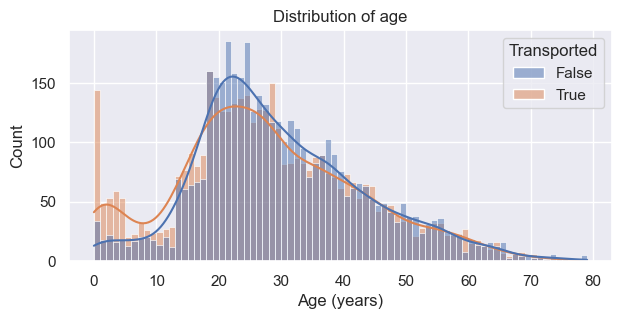

In [52]:
# Figure size
plt.figure(figsize=(7,3))

# Construct Histogram
sns.histplot(data=train_df, x='Age', hue='Transported', binwidth=1, kde=True)

# Plot labels
plt.title('Distribution of age')
plt.xlabel('Age (years)')

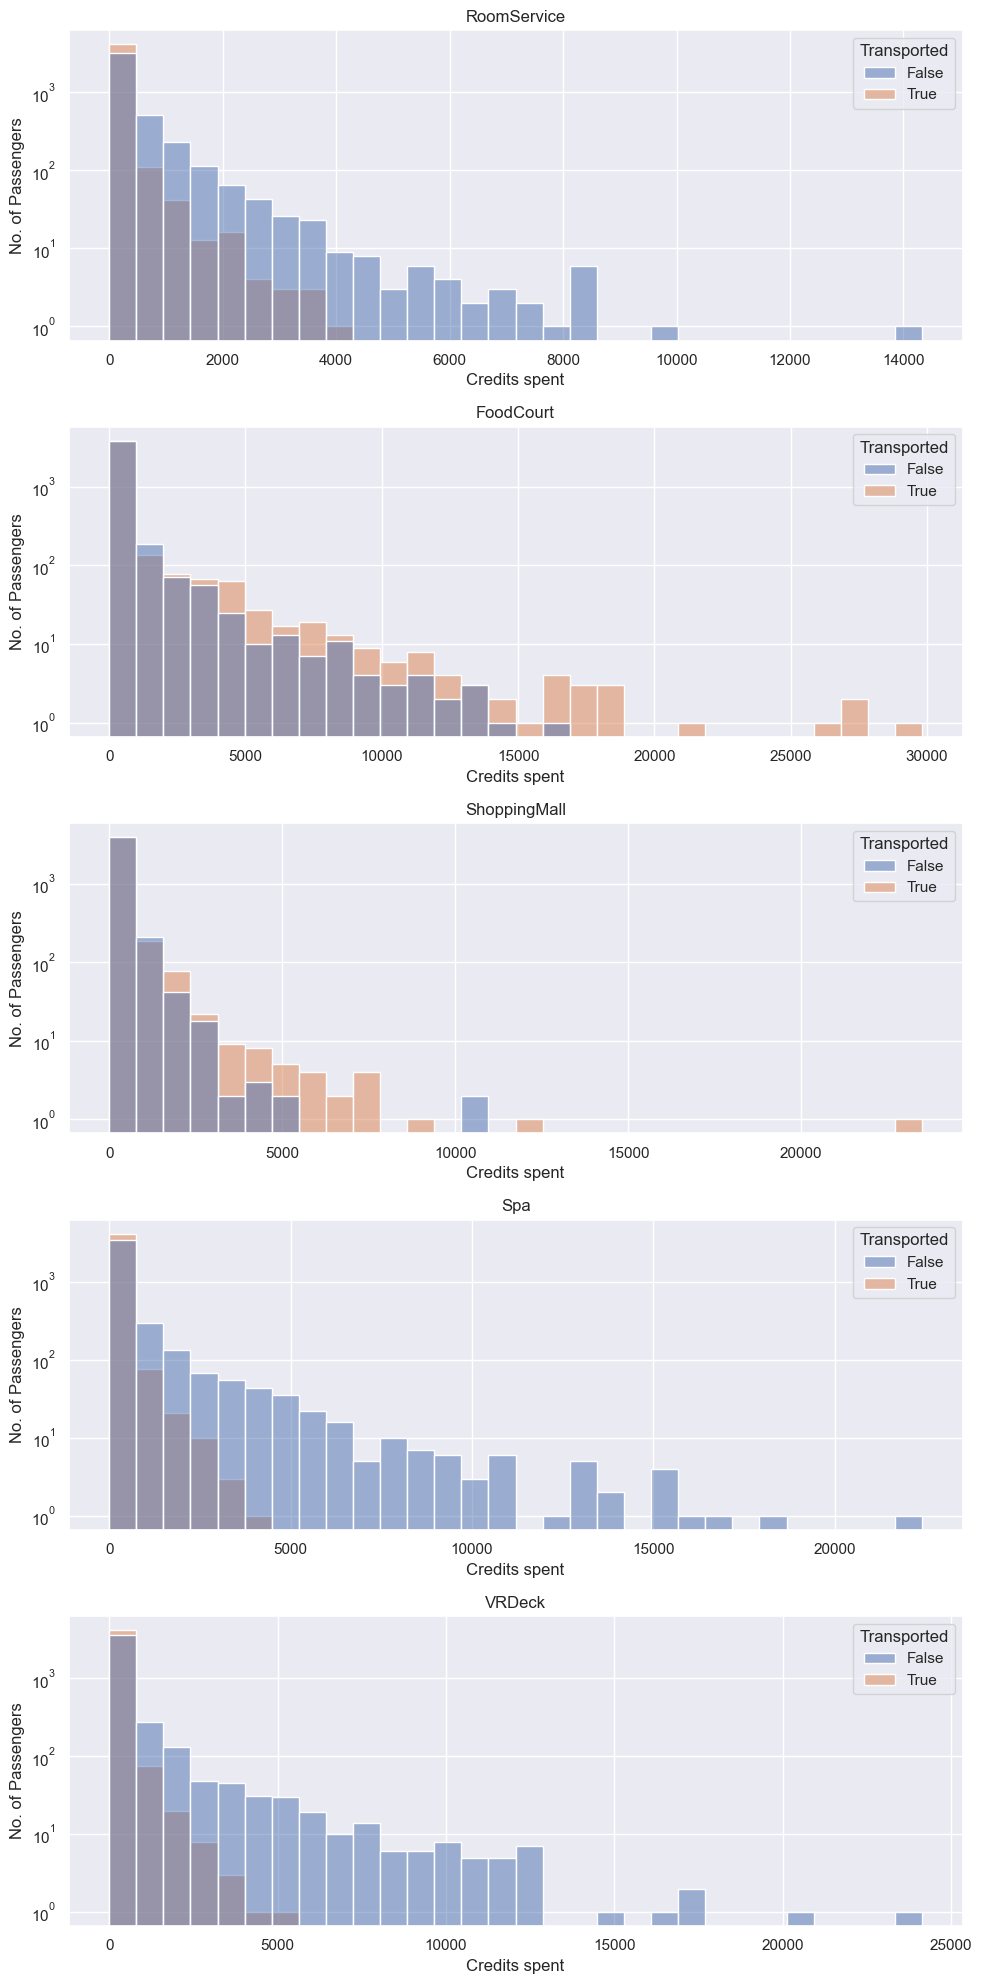

In [53]:
# Credit spending features
total_spent=['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

# Plot expenditure features
fig=plt.figure(figsize=(10,20))
for i, var_name in enumerate(total_spent):
    # Left plot
    ax=fig.add_subplot(5,1,i+1)
    sns.histplot(data=train_df, x=var_name, axes=ax, bins=30, kde=False, hue='Transported')
    ax.set_title(var_name)
    ax.set_yscale('log')  # Setting y-axis to logarithmic scale
    ax.set_xlabel("Credits spent")  
    ax.set_ylabel("No. of Passengers")
    
    
fig.tight_layout()  # Improves appearance a bit
plt.show()

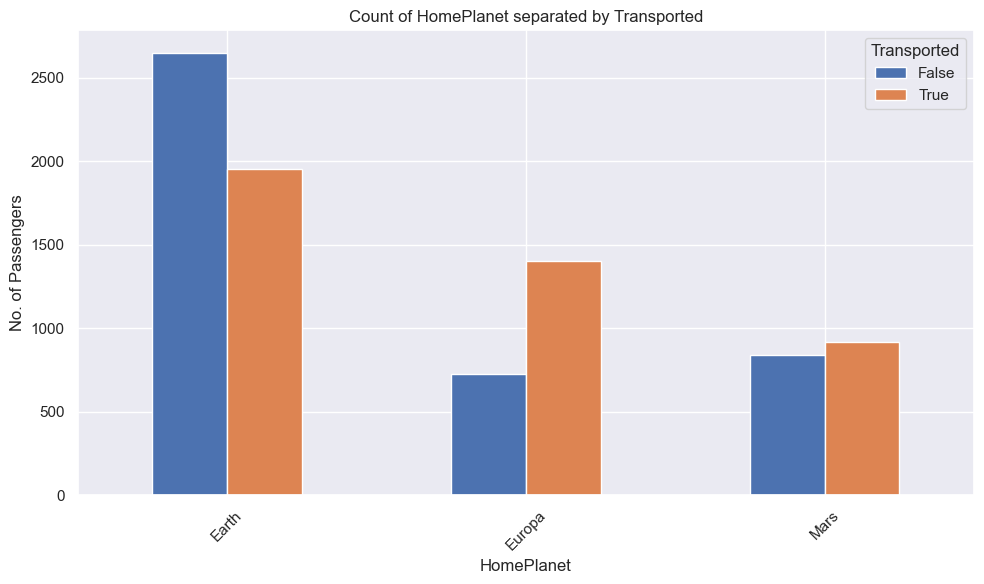

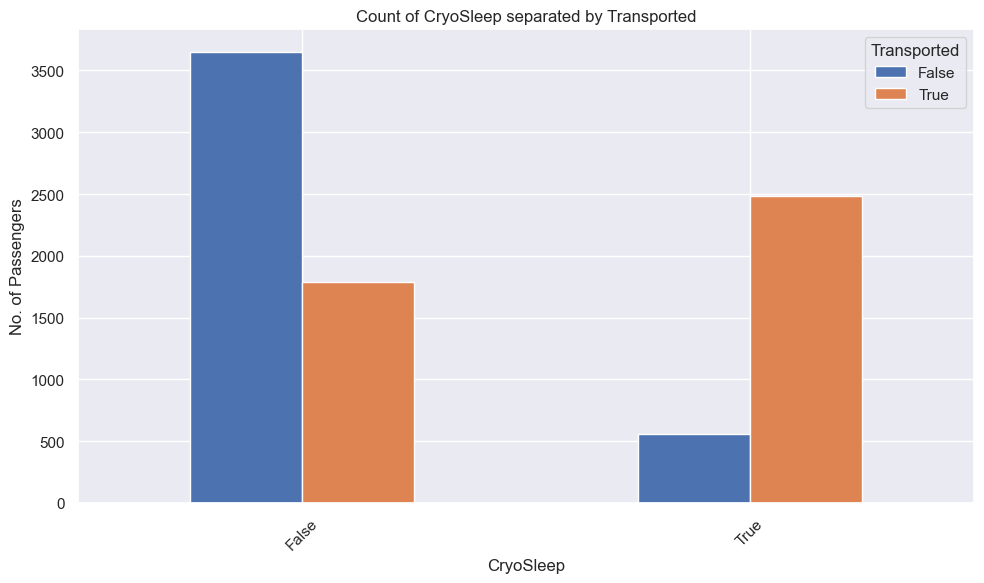

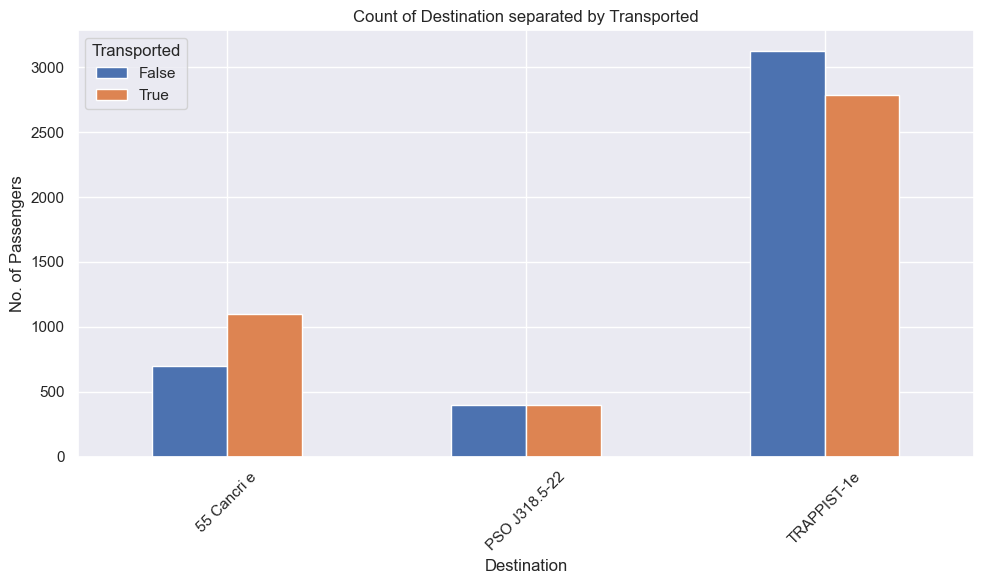

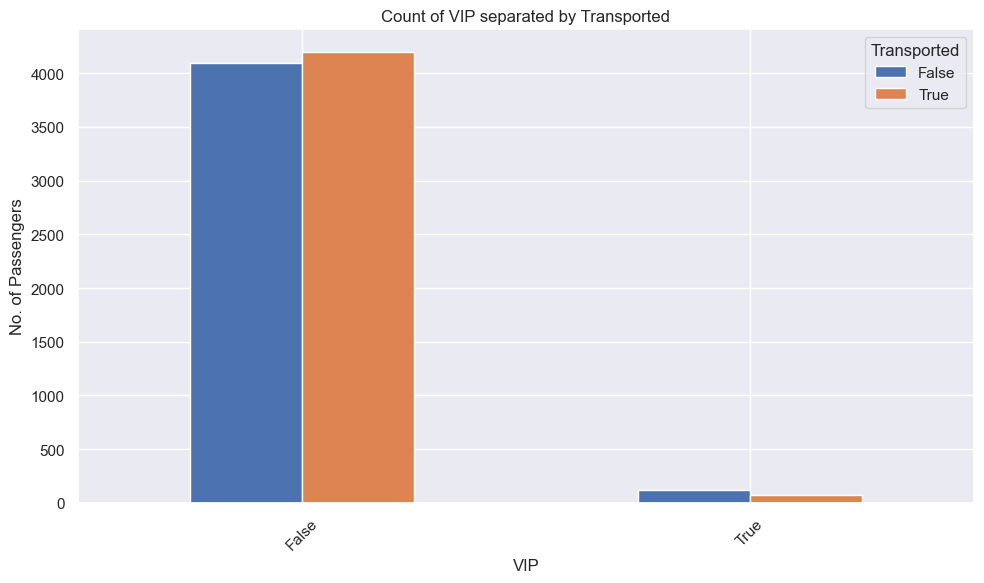

In [54]:
categorial_features=['HomePlanet', 'CryoSleep', 'Destination', 'VIP']

for i, var in enumerate(categorial_features):
    counts = train_df.groupby([var, 'Transported']).size().unstack()
    counts.plot(kind='bar', stacked=False, figsize=(10, 6))
    plt.title('Count of ' + var +' separated by Transported')
    plt.xlabel(var)
    plt.ylabel('No. of Passengers')
    plt.xticks(rotation=45)
    plt.legend(title='Transported')
    plt.tight_layout()
    plt.show()


### Combine the train data and test data 
- This allows for easy cleaning on the whole data at once

In [55]:
# Function to combine train and test dataframes
def combine_df(train_df, test_df):
    combined_df = pd.concat([train_df, test_df], ignore_index=True)
    return combined_df
def separate_df(combined_df, train_df_len, test_df_len):
    train_df = combined_df.iloc[:train_df_len]
    test_df = combined_df.iloc[train_df_len:train_df_len + test_df_len]
    return train_df, test_df

# Combine train and test dataframes
full_df = combine_df(train_df, test_df)

### Check for duplicates in the dataset

In [56]:
def print_duplicates_info(df):
    num_duplicates = df.duplicated().sum()
    percentage_duplicates = np.round(100 * num_duplicates / len(df), 1)
    print(f'Duplicates in dataset: {num_duplicates}, ({percentage_duplicates}%)')

print_duplicates_info(full_df)

Duplicates in dataset: 0, (0.0%)


### Check for null values in the dataset

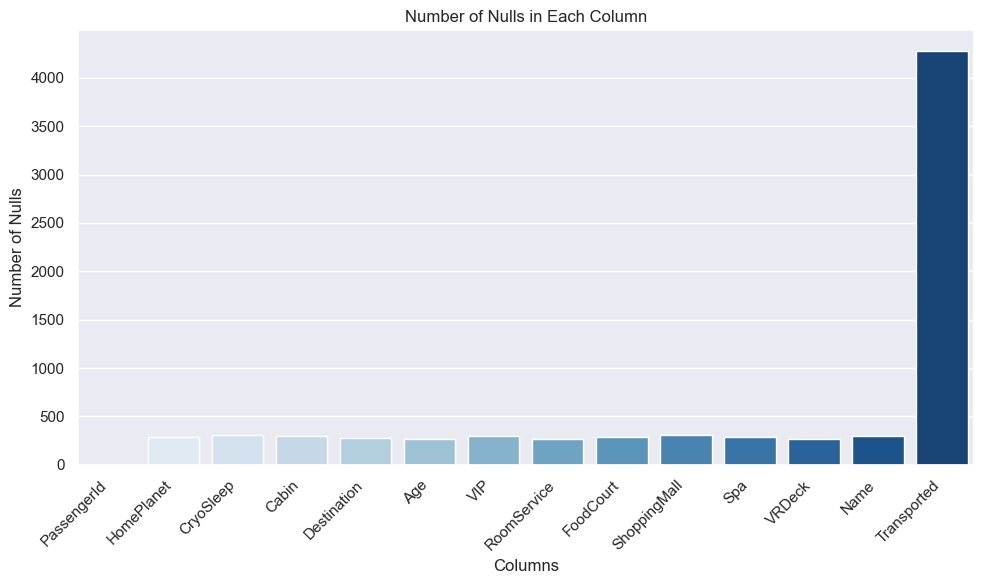

In [57]:
def compute_null_counts(df):
    columns = []
    null_counts = []

    for column in df.columns:
        null_count = df[column].isnull().sum()
        columns.append(column)
        null_counts.append(null_count)

    null_data = pd.DataFrame({'Column': columns, 'Null Count': null_counts})
    return null_data

def plot_null_counts(null_data):
    plt.figure(figsize=(10, 6))
    sns.barplot(data=null_data, x='Column', y='Null Count', palette='Blues')
    plt.xlabel('Columns')
    plt.ylabel('Number of Nulls')
    plt.title('Number of Nulls in Each Column')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

null_data = compute_null_counts(full_df)
plot_null_counts(null_data)

### Note: To get a clear comparison, transported column is removed 

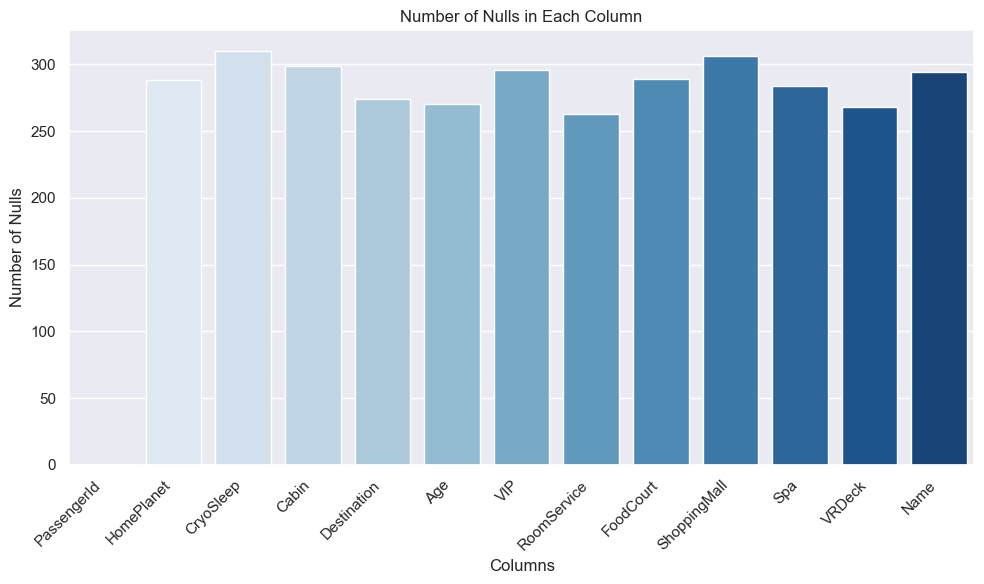

In [58]:
def compute_null_counts_without_transported(df):
    columns = []
    null_counts = []

    for column in df.columns:
        if column != 'Transported':  # Skip the 'Transported' column because we
            null_count = df[column].isnull().sum()
            columns.append(column)
            null_counts.append(null_count)

    null_data = pd.DataFrame({'Column': columns, 'Null Count': null_counts})
    return null_data

null_data_without_transported = compute_null_counts_without_transported(full_df)
plot_null_counts(null_data_without_transported)

### Looking at the null values in the dataset as a percentage
- Computing the percentages of the null values in the data provides insights to the completeness of the dataset
- it helps to understand the proportion of missing values to the whole data and how much of an effect it can have to the overall training of the data

In [59]:
def compute_null_percentages(df):
    total_rows = len(df)
    columns = []
    null_percentages = []

    for column in df.columns:
        if column != 'Transported':
            null_count = df[column].isnull().sum()
            null_percentage = (null_count / total_rows) * 100
            columns.append(column)
            null_percentages.append(null_percentage)

    null_percentage_data = pd.DataFrame({'Column': columns, 'Null Percentage': null_percentages})
    return null_percentage_data

null_percentage_data = compute_null_percentages(full_df)
print(null_percentage_data)

          Column  Null Percentage
0    PassengerId         0.000000
1     HomePlanet         2.220509
2      CryoSleep         2.390131
3          Cabin         2.305320
4    Destination         2.112567
5            Age         2.081727
6            VIP         2.282190
7    RoomService         2.027756
8      FoodCourt         2.228219
9   ShoppingMall         2.359291
10           Spa         2.189668
11        VRDeck         2.066307
12          Name         2.266769


## Different Approach on working out Null Values for Different Models

### Rationale:
- different models achieve different accuracies based on how the data is cleaned
- the three approaches below show how cleaning of data was considered
- based on numerous testing, specific models used different cleaning approaches which gave higher accuracies

### Creating different data frames to peform different cleaning methods on

In [60]:
df1=full_df
dfAidan=full_df

df4=full_df
df5=full_df
df6=full_df
df7=full_df

In [71]:
dfErnest=full_df

## Filling Null Categorical Variables with Mode and Numerical Variables with Mean

This function fills null values in categorical variables of a DataFrame with the mode of each column.

### Parameters:
- `df`: DataFrame: The DataFrame containing categorical variables with null values.
- `categorical_variables`: list: List of categorical variable names.


In [61]:
def filling_null_categorical_vars_with_mode(df,categorical_variables):
    for cat_col in categorical_variables:
        if cat_col!="Name":
            df[cat_col] = df[cat_col].fillna(df[cat_col].mode()[0])

def filling_null_numerical_vars_with_mean(df, numerical_variables):
    for num_col in numerical_variables:
        df[num_col] = df[num_col].fillna(df[num_col].mean())
        


## Filling Null Values using KNNImputer and OneHotEncoder

This function fills missing values in a DataFrame using `KNNImputer` for numeric columns and `OneHotEncoder` for categorical columns.

### Parameters:
- `df`: DataFrame: The DataFrame containing missing values.

### Returns:
- `DataFrame`: The DataFrame with missing values filled using KNNImputer and OneHotEncoder.


In [63]:
# Define the function to calculate family size
def calculate_family_size(df):
    df[['FirstName', 'LastName']] = df['Name'].str.split(expand=True)
    cabin_split = df['Cabin'].str.split('/', expand=True)
    cabin_split.columns = ['Deck', 'Room_Number', 'Side']
    df = pd.concat([df, cabin_split], axis=1)
    df.drop(columns=['Cabin', 'Name'], inplace=True)
    
    family_counts = df.groupby(['LastName', 'Room_Number'])['LastName'].transform('count')
    df['FamilySize'] = family_counts
    
    return df

# Define the function to remove outliers from the 'Age' column
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Replace outliers with the mean value of the column
    df.loc[df[column] < lower_bound, column] = df[column].mean()
    df.loc[df[column] > upper_bound, column] = df[column].mean()
    
    return df

# Call the function to calculate family size
dfAidan = calculate_family_size(dfAidan)

# Calculate the mean age before removing outliers
mean_age_outliers = dfAidan['Age'].mean()

# Replace outliers with the mean age
dfAidan = remove_outliers(dfAidan, 'Age')

# Calculate the mean age after removing outliers
mean_age = dfAidan['Age'].mean()

# Print the mean age
print("Mean Age (before removing outliers):", mean_age_outliers)
print("Mean Age (after removing outliers):", mean_age)

Mean Age (before removing outliers): 28.771968503937007
Mean Age (after removing outliers): 28.404402876805754


In [65]:
# Creating interaction features and adding more features
def create_interaction_features(df):
    # Age group
    df['Age_Group'] = pd.cut(df['Age'], bins=[0, 18, 30, 50, 100], labels=['Child', 'Young Adult', 'Adult', 'Elderly'])

    
    # Family survival rate (assuming 'LastName' and 'Room_Number' are available)
    df['Family_Survival_Rate'] = df.groupby(['LastName', 'Room_Number'])['Transported'].transform('mean')

    
    return df

# Create interaction features and additional features
dfAidan = create_interaction_features(dfAidan)

# Display the updated dataframe
dfAidan.head()


,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,FirstName,LastName,Deck,Room_Number,Side,FamilySize,Age_Group,Family_Survival_Rate
0,0001_01,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False,Maham,Ofracculy,B,0,P,1.0,Adult,0.0
1,0002_01,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True,Juanna,Vines,F,0,S,1.0,Young Adult,1.0
2,0003_01,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False,Altark,Susent,A,0,S,2.0,Elderly,0.0
3,0003_02,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False,Solam,Susent,A,0,S,2.0,Adult,0.0
4,0004_01,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,True,Willy,Santantines,F,1,S,1.0,Child,1.0


In [73]:
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OneHotEncoder

def filling_nulls_using_KNNImputer_and_OneHotEncoder(df):
    # Identify columns with missing values
    columns_with_missing = df.columns[df.isnull().any()]
    
    # Separate numeric and categorical columns
    numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
    categorical_cols = list(set(columns_with_missing) - set(numeric_cols))
    
    # Apply one-hot encoding to categorical columns
    if categorical_cols:
        df_categorical = df[categorical_cols]
        encoder = OneHotEncoder(drop='if_binary')
        df_categorical_encoded = pd.DataFrame(encoder.fit_transform(df_categorical))
        df_categorical_encoded.columns = encoder.get_feature_names_out(categorical_cols)
    
    # Fill missing values in numeric columns using KNNImputer
    if len(numeric_cols) != 0:  # Check if numeric_cols is not empty
        imputer = KNNImputer()
        df_numeric = df[numeric_cols]
        df_numeric_filled = pd.DataFrame(imputer.fit_transform(df_numeric), columns=df_numeric.columns)
    
    # Merge filled numeric columns with one-hot encoded categorical columns
    if len(numeric_cols) != 0 and len(categorical_cols) != 0:
        df = pd.concat([df_numeric_filled, df_categorical_encoded], axis=1)
    elif len(categorical_cols) != 0:
        df = df_categorical_encoded
    elif len(numeric_cols) != 0:
        df = df_numeric_filled
    
    return df

filling_nulls_using_KNNImputer_and_OneHotEncoder(dfAidan)

ValueError: Length mismatch: Expected axis has 1 elements, new values have 7237 elements

## Filling Null values column by column

- This approach takes an in depth analysis of the missing data and how they relate with other factors
- By cleaning the data column by column offers a greater opportunity of having a good training data


### Filling Null Values in the HomePlanet Column
- We are using the relationship between the Destination and the planet an individual came form

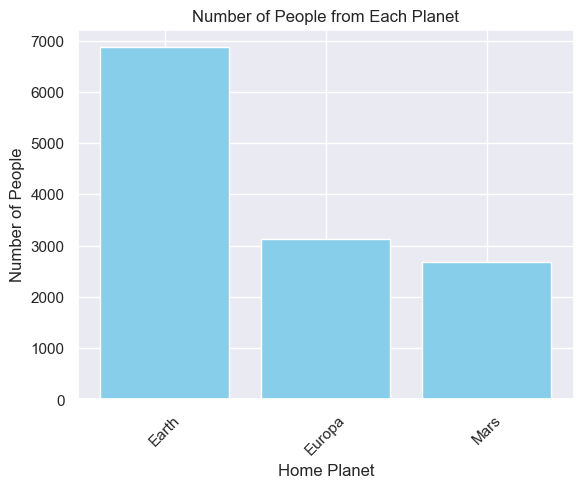

In [74]:
# Create a DataFrame with the count of people from each planet
planet_counts = dfErnest['HomePlanet'].value_counts()

# Plotting
plt.bar(planet_counts.index, planet_counts.values, color='skyblue')
plt.title('Number of People from Each Planet')
plt.xlabel('Home Planet')
plt.ylabel('Number of People')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()

- To see how many possible destinations we have:

In [75]:
print("Number of unique destinations:", dfErnest['Destination'].nunique())


Number of unique destinations: 3


- To see the count of people going to each unique Destination

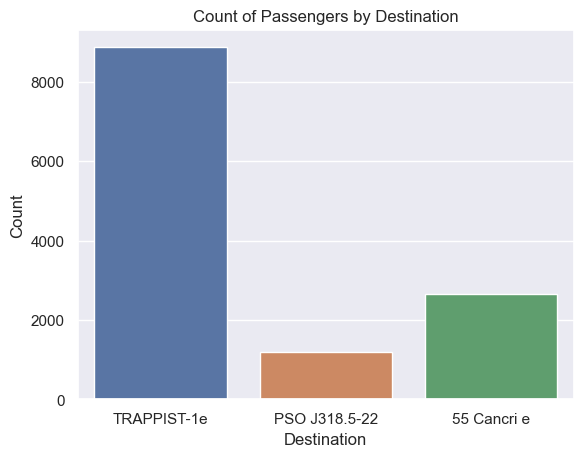

In [76]:
sb.countplot(data=dfErnest, x='Destination')
plt.xlabel('Destination')
plt.ylabel('Count')
plt.title('Count of Passengers by Destination')
plt.show()

### Note: It is clear that more people are going to TRAPPIST-1e, 55 Cancri-e and PSO J318.5-22 respectively

- For each destination, how many people from each planet are going there:

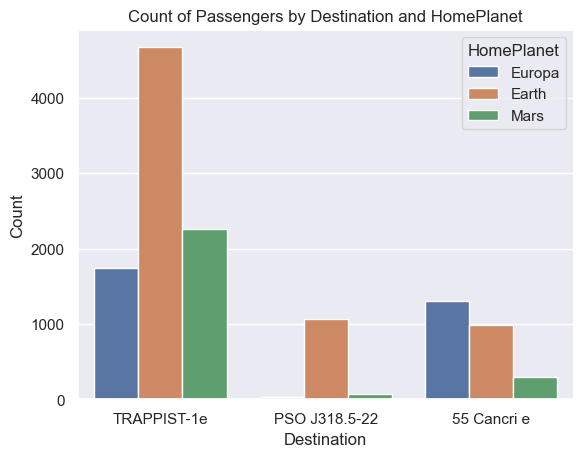

In [77]:

sb.countplot(data=dfErnest, x='Destination', hue='HomePlanet')
plt.xlabel('Destination')
plt.ylabel('Count')
plt.title('Count of Passengers by Destination and HomePlanet')
plt.legend(title='HomePlanet')
plt.show()

- How many people from each planet are VIP or not:

- Group by both HomePlanet and VIP, then count the occurrences

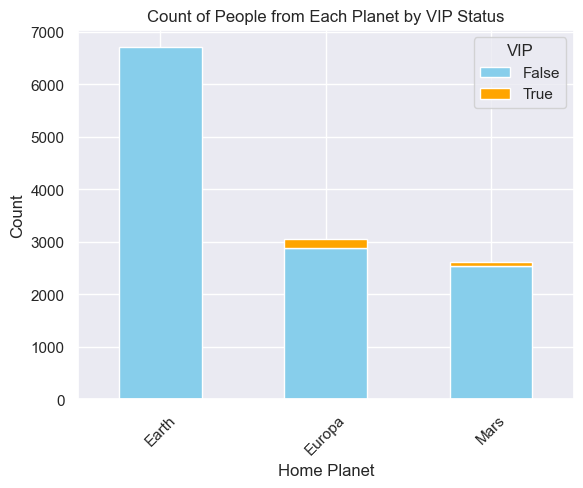

In [78]:
planet_vip_counts = dfErnest.groupby(['HomePlanet', 'VIP']).size().unstack(fill_value=0)

# Plotting
planet_vip_counts.plot(kind='bar', stacked=True, color=['skyblue', 'orange'])
plt.title('Count of People from Each Planet by VIP Status')
plt.xlabel('Home Planet')
plt.ylabel('Count')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend(title='VIP')
plt.show()

- Age distribution of People from each Planet:

In [79]:
grouped = dfErnest.groupby('HomePlanet')['Age']

# Calculate quartiles
quartiles = grouped.describe(percentiles=[0.25, 0.5, 0.75])

# Print quartiles in words
for planet, data in quartiles.iterrows():
    print(f"HomePlanet: {planet}")
    print(f"25th Percentile (Q1): {data['25%']:.2f} years")
    print(f"Median (Q2): {data['50%']:.2f} years")
    print(f"75th Percentile (Q3): {data['75%']:.2f} years")
    print("")


HomePlanet: Earth
25th Percentile (Q1): 18.00 years
Median (Q2): 23.00 years
75th Percentile (Q3): 34.00 years

HomePlanet: Europa
25th Percentile (Q1): 26.00 years
Median (Q2): 33.00 years
75th Percentile (Q3): 42.00 years

HomePlanet: Mars
25th Percentile (Q1): 20.00 years
Median (Q2): 28.00 years
75th Percentile (Q3): 38.00 years



### Note: This probability distribution should still stand even after the imputation!!!

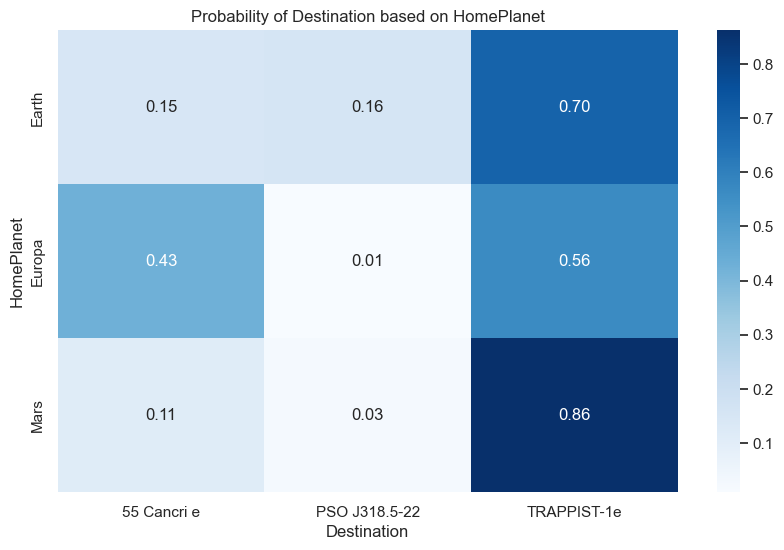

In [80]:
# Count occurrences of each combination of HomePlanet and Destination
counts = dfErnest.groupby(['HomePlanet', 'Destination']).size().unstack(fill_value=0)

# Normalize the counts to get probabilities
probabilities = counts.div(counts.sum(axis=1), axis=0)

# Plot the heatmap
plt.figure(figsize=(10, 6))
sb.heatmap(probabilities, annot=True, cmap='Blues', fmt=".2f", cbar=True)
plt.title('Probability of Destination based on HomePlanet')
plt.xlabel('Destination')
plt.ylabel('HomePlanet')
plt.show()

- Check the number of null values in the HomePlanet column

In [81]:
null_count = dfErnest['HomePlanet'].isnull().sum()
print("Number of null values in HomePlanet column:", null_count)

Number of null values in HomePlanet column: 288


- Attempts to Imputate all null values in HomePlanet based on stats

In [82]:
# Function to impute null values in HomePlanet column based on Destination and VIP status
def impute_home_planet(df):
    for index, row in df.iterrows():
        if pd.isnull(row['HomePlanet']):
            if row['Destination'] == 'TRAPPIS-1e' and row['VIP']:
                age = row['Age']
                if age < 26:
                    df.at[index, 'HomePlanet'] = 'Europa'
                else:
                    df.at[index, 'HomePlanet'] = 'Mars'
            elif row['Destination'] == 'PSO J318.5-22':
                df.at[index, 'HomePlanet'] = 'Earth'
            elif row['Destination'] == '55 Cancri e' and not row['VIP']:
                df.at[index, 'HomePlanet'] = 'Earth'
            elif row['Destination'] == '55 Cancri e' and row['VIP']:
                df.at[index, 'HomePlanet'] = 'Europa'
            else:
                df.at[index, 'HomePlanet'] = 'Earth'
    return df

# Apply the function to impute null values in the HomePlanet column
dfErnest = impute_home_planet(dfErnest)



- Check the number of null values in the HomePlanet column

In [83]:
   null_count = dfErnest['HomePlanet'].isnull().sum()
print("Number of null values in HomePlanet column:", null_count)


Number of null values in HomePlanet column: 0


- This probability distribution should still stand even after the imputation!!!

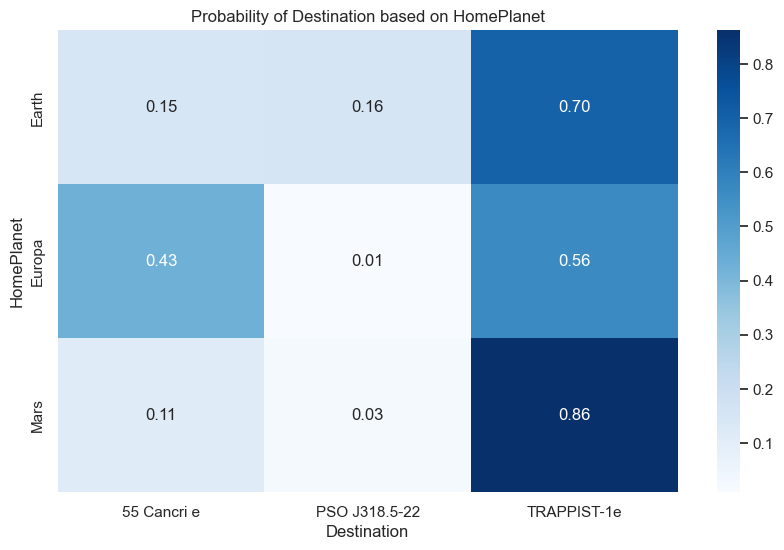

In [84]:
# Count occurrences of each combination of HomePlanet and Destination
counts = dfErnest.groupby(['HomePlanet', 'Destination']).size().unstack(fill_value=0)

# Normalize the counts to get probabilities
probabilities = counts.div(counts.sum(axis=1), axis=0)

# Plot the heatmap
plt.figure(figsize=(10, 6))
sb.heatmap(probabilities, annot=True, cmap='Blues', fmt=".2f", cbar=True)
plt.title('Probability of Destination based on HomePlanet')
plt.xlabel('Destination')
plt.ylabel('HomePlanet')
plt.show()

### Filling Null Values in the CryoSleep Column:


- Relate the CryoSleep with Expenditures

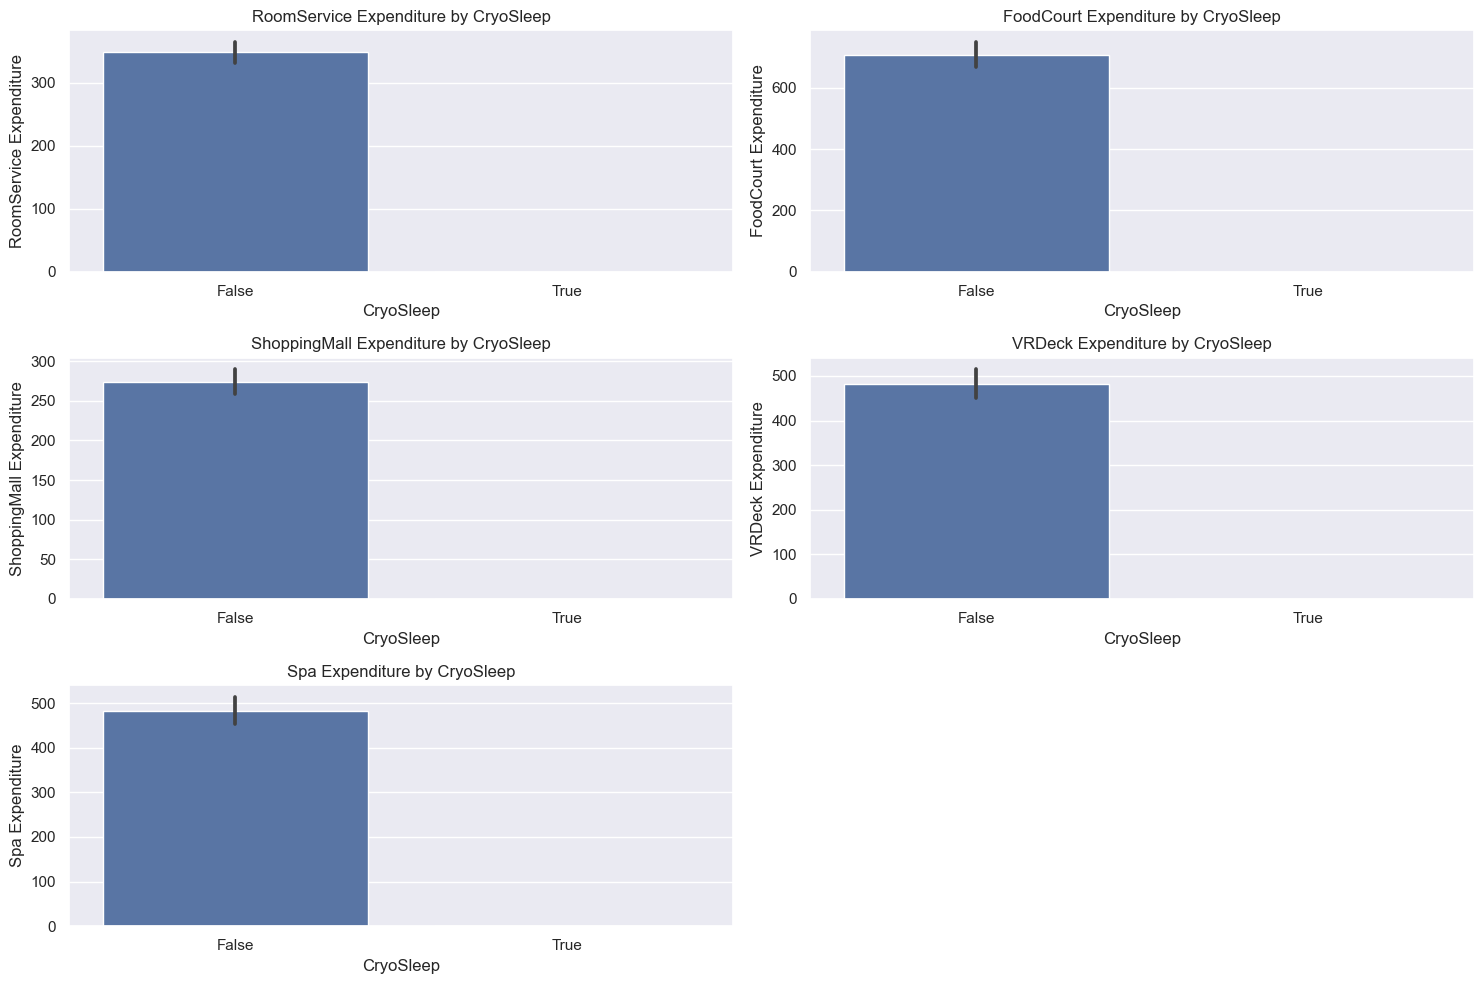

In [85]:
# List of columns
columns = ['RoomService', 'FoodCourt', 'ShoppingMall', 'VRDeck', 'Spa']

# Plotting
plt.figure(figsize=(15, 10))
for i, col in enumerate(columns):
    plt.subplot(3, 2, i+1)  # Adjusted indexing
    sb.barplot(x='CryoSleep', y=col, data=dfErnest)
    plt.title(f'{col} Expenditure by CryoSleep')
    plt.xlabel('CryoSleep')
    plt.ylabel(f'{col} Expenditure')
plt.tight_layout()
plt.show()


### Note: We see that When CryoSleep is True, all expenditures are Zero:

In [86]:
# Fill null values in CryoSleep based on the sum of expenditures
dfErnest['CryoSleep'] = dfErnest['CryoSleep'].fillna((dfErnest['RoomService'] + dfErnest['FoodCourt'] + dfErnest['ShoppingMall'] + dfErnest['VRDeck']) == 0)
null_count = dfErnest['CryoSleep'].isnull().sum()
print("Number of null values in CryoSleep column:", null_count)

Number of null values in CryoSleep column: 0


### Filling Null values for the Cabin Number:

In [87]:
nulls_in_name = dfErnest['Cabin'].isnull().sum()
print("Number of null values in the Cabin column:", nulls_in_name)

Number of null values in the Cabin column: 299


In [88]:
nulls_in_name = dfErnest['Name'].isnull().sum()
print("Number of null values in the Name column:", nulls_in_name)

Number of null values in the Name column: 294


In [89]:
# Count the number of null values in Cabin corresponding to null values in Name
null_cabin_null_name_count = dfErnest[dfErnest['Cabin'].isnull() & dfErnest['Name'].isnull()].shape[0]

print("Number of null values in Cabin corresponding to null values in Name:", null_cabin_null_name_count)


Number of null values in Cabin corresponding to null values in Name: 3


In [90]:
# Initialize a counter for group numbers with no other rows having a non-null Cabin number
count_unique_group_numbers = 0

# Iterate over each row with a null value in the Cabin number column
for index, row in dfErnest[dfErnest['Cabin'].isnull()].iterrows():
    # Extract group number from PassengerId
    group_number = row['PassengerId'].split('_')[0]
    
    # Check if there are other rows with the same group number and a non-null Cabin number
    if dfErnest[(dfErnest['PassengerId'].str.split('_').str[0] == group_number) & (~dfErnest['Cabin'].isnull())].empty:
        count_unique_group_numbers += 1

print("Number of group numbers with no other rows having a non-null Cabin number:", count_unique_group_numbers)

Number of group numbers with no other rows having a non-null Cabin number: 162


In [91]:
def fill_null_cabin(df):
    # Extract group numbers from PassengerId for rows with null Cabin values
    null_cabin_groups = df[df['Cabin'].isnull()]['PassengerId'].str.split('_').str[0]
    
    # Iterate over each null Cabin row
    for index, row in df[df['Cabin'].isnull()].iterrows():
        # Get the group number for the current row
        group_number = row['PassengerId'].split('_')[0]
        
        # Find other rows with the same group number and non-null Cabin values
        similar_group_rows = df[(df['PassengerId'].str.split('_').str[0] == group_number) & (~df['Cabin'].isnull())]
        
        # If there are similar group rows, fill the null Cabin value with the first non-null Cabin value
        if not similar_group_rows.empty:
            df.at[index, 'Cabin'] = similar_group_rows.iloc[0]['Cabin']
    
    return df

# Apply the fill_null_cabin function
dfErnest = fill_null_cabin(dfErnest)


### Note: Rationale
- For every null value in the Cabin column, i want check the corresponding group number(gggg) in 
- the PassengerId column. Then check if there are any other similiar group numbers(gggg) in the 
- PassengerId column with the non-null corresponding values in Cabin column. If so, give that null 
- value the same Cabin value as those having the same group number

In [ ]:
nulls_in_name = dfErnest['Cabin'].isnull().sum()
print("Number of null values in the Cabin column:", nulls_in_name)

In [ ]:
# Count the number of null values in Cabin corresponding to null values in Name
null_cabin_null_name_count = dfErnest[dfErnest['Cabin'].isnull() & dfErnest['Name'].isnull()].shape[0]

print("Number of null values in Cabin corresponding to null values in Name:", null_cabin_null_name_count)

In [94]:
# Initialize a counter for unique last names with no other rows having a non-null Cabin number
count_unique_last_names = 0

# Iterate over each row with a null value in the Cabin number column
for index, row in dfErnest[dfErnest['Cabin'].isnull()].iterrows():
    # Check if the 'Name' column is not null
    if not pd.isnull(row['Name']):
        # Extract the last name from the Name column
        last_name = row['Name'].split()[-1]
    
    # Check if there are other rows with the same last name and a non-null Cabin number
    if dfErnest[(dfErnest['Name'].str.split().str[-1] == last_name) & (~dfErnest['Cabin'].isnull())].empty:
        count_unique_last_names += 1
    
print("Number of unique last names with no other rows having a non-null Cabin number:", count_unique_last_names)

Number of unique last names with no other rows having a non-null Cabin number: 4


In [96]:
# Iterate over each row with a null value in the Cabin number column
for index, row in dfErnest[dfErnest['Cabin'].isnull()].iterrows():
    # Check if the 'Name' column is not null
    if not pd.isnull(row['Name']):
        # Extract the last name from the Name column
        last_name = row['Name'].split()[-1]
    
    # Find other rows with the same last name and a non-null Cabin number
    matching_rows = dfErnest[(dfErnest['Name'].str.split().str[-1] == last_name) & (~dfErnest['Cabin'].isnull())]
    
    # Check if there are any matching rows
    if not matching_rows.empty:
        # Get the Cabin number from the first matching row
        cabin_number = matching_rows.iloc[0]['Cabin']
        
        # Fill in the null value in the Cabin column with the found Cabin number
        dfErnest.at[index, 'Cabin'] = cabin_number
        

### Note: Rationale
- This code iterates over each row with a null value in the Cabin column, 
- extracts the last name from the corresponding Name column,
- finds other rows with the same last name and a non-null Cabin number, and
- fills in the null value in the Cabin column with the found Cabin number.

In [97]:
nulls_in_name = dfErnest['Cabin'].isnull().sum()
print("Number of null values in the Cabin column:", nulls_in_name)

Number of null values in the Cabin column: 5


In [98]:
nulls_in_name = dfErnest['Name'].isnull().sum()
print("Number of null values in the Name column:", nulls_in_name)

Number of null values in the Name column: 294


In [99]:
# Iterate over each row with a null value in the Name column
for index, row in dfErnest[dfErnest['Name'].isnull()].iterrows():
    # Extract the Cabin number from the corresponding Cabin column
    cabin_number = row['Cabin']
    
    # Find other rows with the same Cabin number and a non-null Name
    matching_rows = dfErnest[(dfErnest['Cabin'] == cabin_number) & (~dfErnest['Name'].isnull())]
    
    # Check if there are any matching rows
    if not matching_rows.empty:
        # Get the first matching row
        matching_row = matching_rows.iloc[0]
        
        # Extract the last name from the non-null Name value
        last_name = matching_row['Name'].split()[-1]
        
        # Fill in the null value in the Name column with the generated name
        dfErnest.at[index, 'Name'] = "Firstname A " + last_name


In [100]:
# Iterate over each row with a null value in the Name column
for index, row in dfErnest[dfErnest['Name'].isnull()].iterrows():
    # Extract the group number (gggg) from the corresponding PassengerId column
    group_number = row['PassengerId'].split('_')[0]
    
    # Find other rows with the same group number and a non-null Name
    matching_rows = dfErnest[(dfErnest['PassengerId'].str.split('_').str[0] == group_number) & (~dfErnest['Name'].isnull())]
    
    # Check if there are any matching rows
    if not matching_rows.empty:
        # Get the first matching row
        matching_row = matching_rows.iloc[0]
        
        # Extract the last name from the non-null Name value
        last_name = matching_row['Name'].split()[-1]
        
        # Fill in the null value in the Name column with the generated name
        dfErnest.at[index, 'Name'] = "Firstname A " + last_name


In [101]:
nulls_in_name = dfErnest['Name'].isnull().sum()
print("Number of null values in the Name column:", nulls_in_name)

Number of null values in the Name column: 155


In [103]:
# Initialize a counter for unique last names with no other rows having a non-null Cabin number
count_unique_last_names = 0

# Iterate over each row with a null value in the Cabin number column
for index, row in dfErnest[dfErnest['Cabin'].isnull()].iterrows():
    # Check if the 'Name' column is not null
    if not pd.isnull(row['Name']):
        # Extract the last name from the Name column
        last_name = row['Name'].split()[-1]
    
    # Check if there are other rows with the same last name and a non-null Cabin number
    if dfErnest[(dfErnest['Name'].str.split().str[-1] == last_name) & (~dfErnest['Cabin'].isnull())].empty:
        count_unique_last_names += 1

print("Number of unique last names with no other rows having a non-null Cabin number:", count_unique_last_names)

Number of unique last names with no other rows having a non-null Cabin number: 5


In [104]:
# Initialize a counter for group numbers with no other rows having a non-null Cabin number
count_unique_group_numbers = 0

# Iterate over each row with a null value in the Cabin number column
for index, row in dfErnest[dfErnest['Cabin'].isnull()].iterrows():
    # Extract group number from PassengerId
    group_number = row['PassengerId'].split('_')[0]
    
    # Check if there are other rows with the same group number and a non-null Cabin number
    if dfErnest[(dfErnest['PassengerId'].str.split('_').str[0] == group_number) & (~dfErnest['Cabin'].isnull())].empty:
        count_unique_group_numbers += 1

print("Number of group numbers with no other rows having a non-null Cabin number:", count_unique_group_numbers)

Number of group numbers with no other rows having a non-null Cabin number: 5


In [105]:
# Iterate over each row with a null value in the Cabin column
for index, row in dfErnest[dfErnest['Cabin'].isnull()].iterrows():
    # Print the PassengerId and Name for the current row
    print("PassengerId:", row['PassengerId'], "Name:", row['Name'])

PassengerId: 0502_01 Name: Pigars Swell
PassengerId: 2117_01 Name: Azet Rocketedy
PassengerId: 3553_01 Name: Wafox Maie
PassengerId: 6385_01 Name: Possh Duncy
PassengerId: 3367_01 Name: nan


In [106]:
# Drop rows with null values in the Cabin column
dfErnest.dropna(subset=['Cabin'], inplace=True)

In [107]:
nulls_in_name = dfErnest['Cabin'].isnull().sum()
print("Number of null values in the Cabin column:", nulls_in_name)

Number of null values in the Cabin column: 0


### Filling Null values in VIP

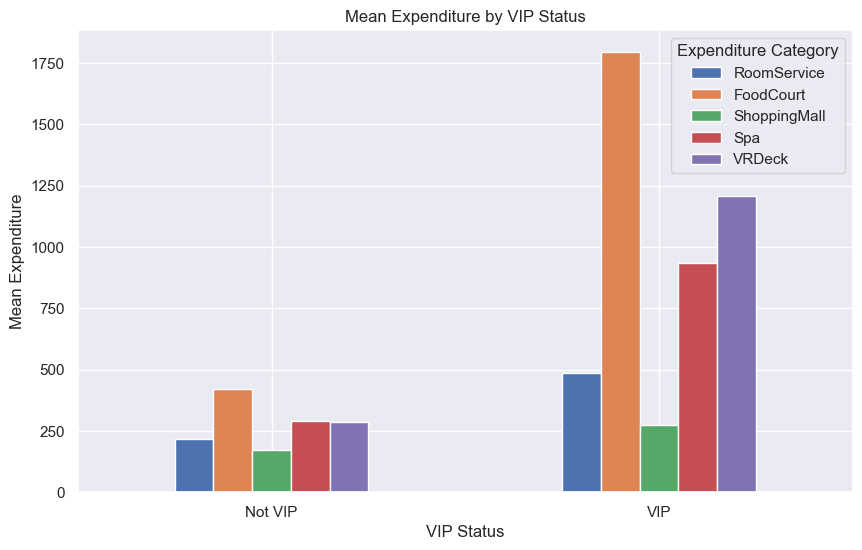

In [108]:
# Group by VIP and calculate the mean expenditure for each category
expenditure_means = dfErnest.groupby('VIP')[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].mean()

# Plot the bar graph
expenditure_means.plot(kind='bar', figsize=(10, 6))
plt.title('Mean Expenditure by VIP Status')
plt.xlabel('VIP Status')
plt.ylabel('Mean Expenditure')
plt.xticks(ticks=[0, 1], labels=['Not VIP', 'VIP'], rotation=0)
plt.legend(title='Expenditure Category')
plt.show()

In [110]:
# Define a function to predict the VIP status based on expenditure and HomePlanet
def predict_vip(row):
    if row['VRDeck'] > row['Spa']:
        return True
    elif row['Spa'] > row['VRDeck']:
        return False
    else:
        if row['HomePlanet'] == 'Earth':
            return False
        elif row['HomePlanet'] == 'Europa':
            return True
        elif row['HomePlanet'] == 'Mars':
            return True  # If HomePlanet is Mars, VIP should be True
        else:
            return None  # Return None for other cases

# Apply the function to rows with null values in the VIP column
dfErnest.loc[dfErnest['VIP'].isnull(), 'VIP'] = dfErnest[dfErnest['VIP'].isnull()].apply(predict_vip, axis=1)



In [111]:
null_vip_count = dfErnest['VIP'].isnull().sum()
print("Number of null values in the VIP column:", null_vip_count)


Number of null values in the VIP column: 0


### Filling null values in the Destination column

- For each destination, how many people from each planet are going there:

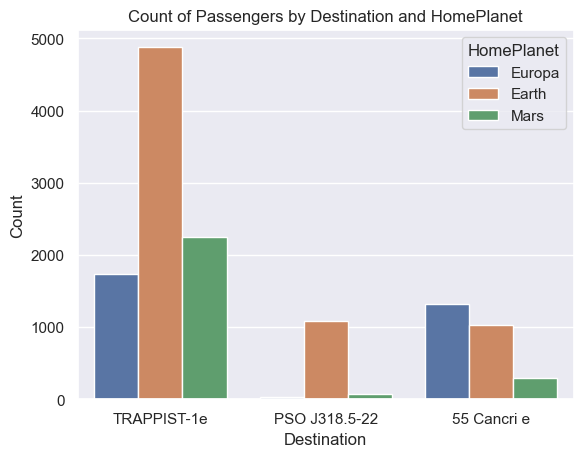

In [112]:
sb.countplot(data=dfErnest, x='Destination', hue='HomePlanet')
plt.xlabel('Destination')
plt.ylabel('Count')
plt.title('Count of Passengers by Destination and HomePlanet')
plt.legend(title='HomePlanet')
plt.show()

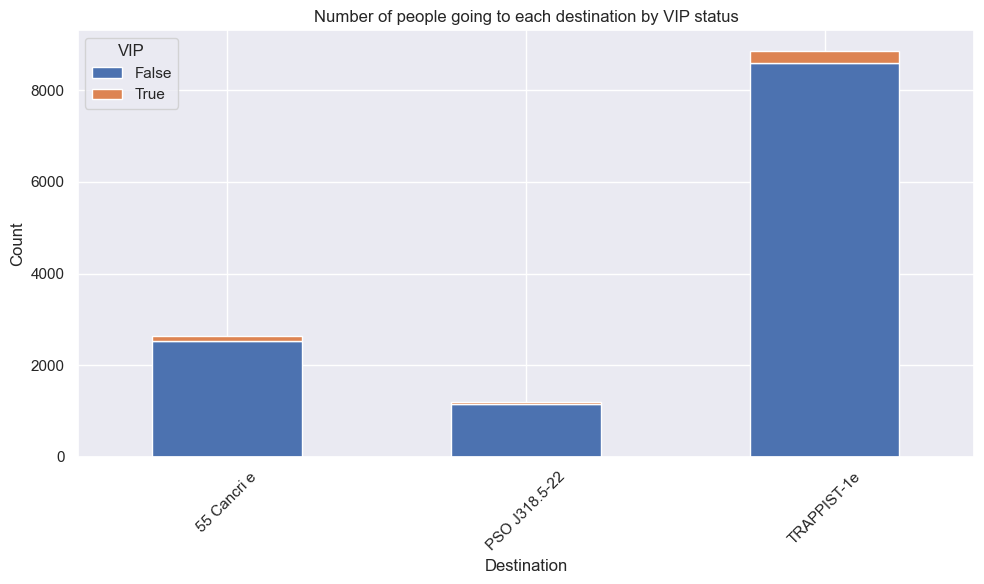

In [113]:
# Group data by Destination and VIP
destination_vip_counts = dfErnest.groupby(['Destination', 'VIP']).size().unstack(fill_value=0)

# Plot the data
destination_vip_counts.plot(kind='bar', stacked=True, figsize=(10, 6))

# Add labels and title
plt.xlabel('Destination')
plt.ylabel('Count')
plt.title('Number of people going to each destination by VIP status')

# Show the plot
plt.legend(title='VIP')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

In [114]:
# Fill null values in Destination based on HomePlanet and VIP status
dfErnest.loc[(dfErnest['HomePlanet'] == 'Earth') & (dfErnest['VIP'] == False) & (dfErnest['Destination'].isnull()), 'Destination'] = 'PSO J318.5-22'
dfErnest.loc[(dfErnest['HomePlanet'] == 'Earth') & (dfErnest['VIP'] == True) & (dfErnest['Destination'].isnull()), 'Destination'] = 'TRAPPIST-1e'
dfErnest.loc[(dfErnest['HomePlanet'] == 'Europa') & (dfErnest['VIP'] == False) & (dfErnest['Destination'].isnull()), 'Destination'] = '55 Cancri e'
dfErnest.loc[(dfErnest['HomePlanet'] == 'Europa') & (dfErnest['VIP'] == True) & (dfErnest['Destination'].isnull()), 'Destination'] = 'TRAPPIST-1e'
dfErnest.loc[(dfErnest['HomePlanet'] == 'Mars') & (dfErnest['VIP'] == False) & (dfErnest['Destination'].isnull()), 'Destination'] = '55 Cancri e'
dfErnest.loc[(dfErnest['HomePlanet'] == 'Mars') & (dfErnest['VIP'] == True) & (dfErnest['Destination'].isnull()), 'Destination'] = 'TRAPPIST-1e'


In [115]:
# Count the number of null values in the Destination column
null_destinations = dfErnest['Destination'].isnull().sum()
print("Number of null values in the Destination column:", null_destinations)


Number of null values in the Destination column: 0


In [116]:
# Count the number of null values in the Destination column where VIP column is also null
null_destinations_vip = dfErnest[dfErnest['Destination'].isnull() & dfErnest['VIP'].isnull()].shape[0]
print("Number of null values in the Destination column corresponding to null values in the VIP column:", null_destinations_vip)


Number of null values in the Destination column corresponding to null values in the VIP column: 0


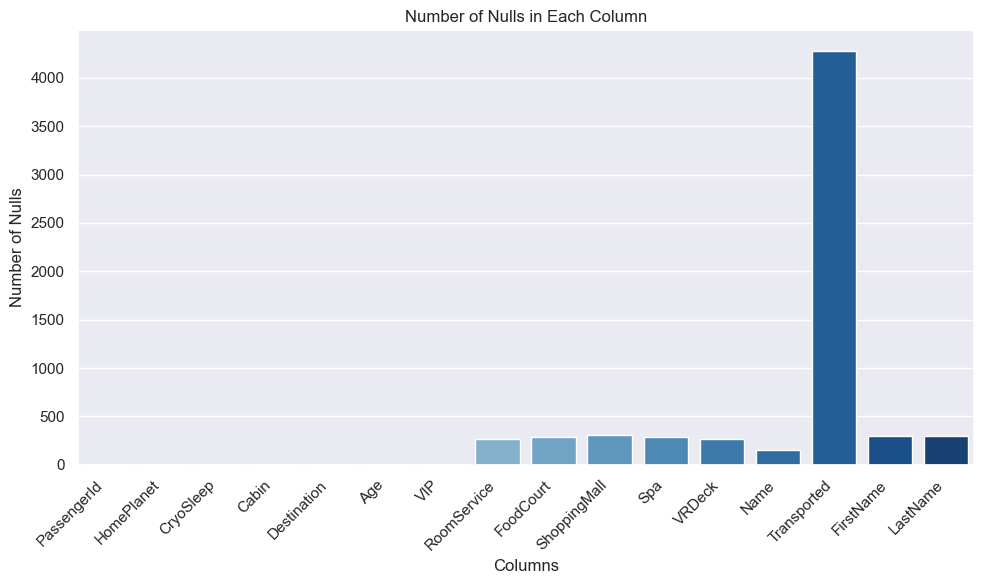

In [124]:
def null_updates_in_dataframe(df):
    # Create empty lists to store column names and null counts
    columns = []
    null_counts = []

    # Iterate over each column and append the column name and null count to the lists
    for column in df.columns:
        null_count = df[column].isnull().sum()
        columns.append(column)
        null_counts.append(null_count)

    # Create a DataFrame from the lists
    null_data = pd.DataFrame({'Column': columns, 'Null Count': null_counts})

    # Plotting
    plt.figure(figsize=(10, 6))
    sb.barplot(data=null_data, x='Column', y='Null Count', palette='Blues')
    plt.xlabel('Columns')
    plt.ylabel('Number of Nulls')
    plt.title('Number of Nulls in Each Column')
    plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
    plt.tight_layout()
    plt.show()
    
null_updates_in_dataframe(dfErnest)

### Filling null values for the Age:

- Age distribution of People from each Planet:

In [118]:
grouped = dfErnest.groupby('HomePlanet')['Age']

# Calculate quartiles
quartiles = grouped.describe(percentiles=[0.25, 0.5, 0.75])

# Print quartiles in words
for planet, data in quartiles.iterrows():
    print(f"HomePlanet: {planet}")
    print(f"25th Percentile (Q1): {data['25%']:.2f} years")
    print(f"Median (Q2): {data['50%']:.2f} years")
    print(f"75th Percentile (Q3): {data['75%']:.2f} years")
    print("")

HomePlanet: Earth
25th Percentile (Q1): 18.00 years
Median (Q2): 23.00 years
75th Percentile (Q3): 35.00 years

HomePlanet: Europa
25th Percentile (Q1): 26.00 years
Median (Q2): 33.00 years
75th Percentile (Q3): 42.00 years

HomePlanet: Mars
25th Percentile (Q1): 20.00 years
Median (Q2): 28.00 years
75th Percentile (Q3): 38.00 years



In [119]:
null_age_with_zero_spa = dfErnest[dfErnest['Spa'] == 0]['Age'].isnull().sum()
print("Number of null values in the Age column corresponding to Spa being 0:", null_age_with_zero_spa)

Number of null values in the Age column corresponding to Spa being 0: 172


In [120]:
# Impute null values in Age column where Spa expenditure is 0 with 6
dfErnest.loc[(dfErnest['Age'].isnull()) & (dfErnest['Spa'] == 0), 'Age'] = 6

In [121]:
null_vip_count = dfErnest['Age'].isnull().sum()
print("Number of null values in the Age column:", null_vip_count)

Number of null values in the Age column: 98


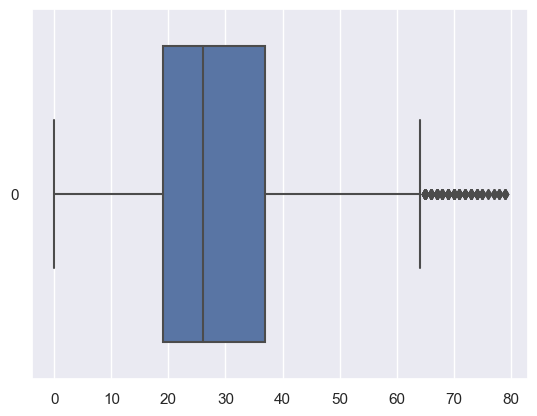

In [122]:
#Imputing 'Age' null values, but first consider outliers

sb.boxplot(dfErnest['Age'],orient='h')
plt.show()

In [123]:
#For training data:
temp = dfErnest[dfErnest['Age'] < 61]['Age'].mean()
dfErnest['Age'] = dfErnest['Age'].fillna(temp)

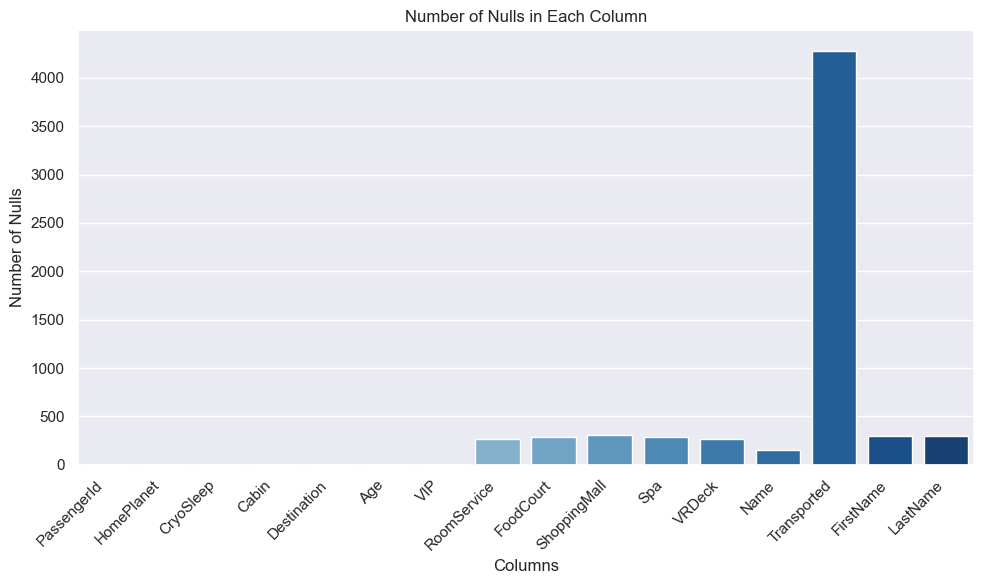

In [125]:
null_updates_in_dataframe(dfErnest)

### Filling null values for RoomService column:

In [126]:
## Calculate summary statistics for RoomService expenditure for VIP and non-VIP individuals
vip_roomservice_stats = dfErnest[dfErnest['VIP'] == True]['RoomService'].describe()
non_vip_roomservice_stats = dfErnest[dfErnest['VIP'] == False]['RoomService'].describe()

# Display the summary statistics
print("Summary statistics for RoomService expenditure among VIP individuals:")
print(vip_roomservice_stats)
print("\nSummary statistics for RoomService expenditure among non-VIP individuals:")
print(non_vip_roomservice_stats)

Summary statistics for RoomService expenditure among VIP individuals:
count     407.000000
mean      397.862408
std       935.836277
min         0.000000
25%         0.000000
50%         0.000000
75%       402.000000
max      8243.000000
Name: RoomService, dtype: float64

Summary statistics for RoomService expenditure among non-VIP individuals:
count    12295.000000
mean       217.160228
std        635.175450
min          0.000000
25%          0.000000
50%          0.000000
75%         45.000000
max      14327.000000
Name: RoomService, dtype: float64


## Function: calculate_outlier_bounds

Calculate lower and upper bounds for outlier detection using the Interquartile Range (IQR) method.

### Parameters:
- **column (pandas Series):** A pandas Series representing the column for which bounds are to be calculated.

### Returns:
- **float, float:** Lower and upper bounds for outlier detection.

### Example Usage:
```python
lower_bound, upper_bound = calculate_outlier_bounds(df['Column'])


In [127]:
def calculate_outlier_bounds(column):
    q1 = column.quantile(0.25)
    q3 = column.quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    return lower_bound, upper_bound


- Remove outliers for RoomService expenditures

In [128]:
lower_bound, upper_bound = calculate_outlier_bounds(dfErnest['RoomService'])
df_cleaned = dfErnest[(dfErnest['RoomService'] >= lower_bound) & (dfErnest['RoomService'] <= upper_bound)]

# Calculate mean and median based on VIP status
mean_vip = df_cleaned[df_cleaned['VIP'] == True]['RoomService'].mean()
median_vip = df_cleaned[df_cleaned['VIP'] == True]['RoomService'].median()

mean_non_vip = df_cleaned[df_cleaned['VIP'] == False]['RoomService'].mean()
median_non_vip = df_cleaned[df_cleaned['VIP'] == False]['RoomService'].median()

# Fill null values based on mean and median
dfErnest.loc[(dfErnest['VIP'] == True) & (dfErnest['RoomService'].isnull()), 'RoomService'] = mean_vip
dfErnest.loc[(dfErnest['VIP'] == False) & (dfErnest['RoomService'].isnull()), 'RoomService'] = mean_non_vip


In [129]:
null_vip_count = dfErnest['RoomService'].isnull().sum()
print("Number of null values in the RoomService column:", null_vip_count)

Number of null values in the RoomService column: 0


### Filling null values For FoodCourt

In [130]:
## Calculate summary statistics for FoodCourt expenditure for VIP and non-VIP individuals
vip_foodcourt_stats = dfErnest[dfErnest['VIP'] == True]['FoodCourt'].describe()
non_vip_foodcourt_stats = dfErnest[dfErnest['VIP'] == False]['FoodCourt'].describe()

# Display the summary statistics
print("Summary statistics for FoodCourt expenditure among VIP individuals:")
print(vip_foodcourt_stats)
print("\nSummary statistics for FoodCourt expenditure among non-VIP individuals:")
print(non_vip_foodcourt_stats)

Summary statistics for FoodCourt expenditure among VIP individuals:
count      405.000000
mean      1469.634568
std       3574.431548
min          0.000000
25%          0.000000
50%         13.000000
75%       1260.000000
max      29813.000000
Name: FoodCourt, dtype: float64

Summary statistics for FoodCourt expenditure among non-VIP individuals:
count    12271.000000
mean       417.780784
std       1460.290520
min          0.000000
25%          0.000000
50%          0.000000
75%         59.500000
max      27071.000000
Name: FoodCourt, dtype: float64


- Remove outliers for FoodCourt expenditures

In [131]:
lower_bound, upper_bound = calculate_outlier_bounds(dfErnest['FoodCourt'])
df_cleaned = dfErnest[(dfErnest['FoodCourt'] >= lower_bound) & (dfErnest['FoodCourt'] <= upper_bound)]

# Calculate mean and median based on VIP status
mean_vip = df_cleaned[df_cleaned['VIP'] == True]['FoodCourt'].mean()
median_vip = df_cleaned[df_cleaned['VIP'] == True]['FoodCourt'].median()

mean_non_vip = df_cleaned[df_cleaned['VIP'] == False]['FoodCourt'].mean()
median_non_vip = df_cleaned[df_cleaned['VIP'] == False]['FoodCourt'].median()

# Fill null values based on mean and median
dfErnest.loc[(dfErnest['VIP'] == True) & (dfErnest['FoodCourt'].isnull()), 'FoodCourt'] = mean_vip
dfErnest.loc[(dfErnest['VIP'] == False) & (dfErnest['FoodCourt'].isnull()), 'FoodCourt'] = mean_non_vip



In [132]:
null_vip_count = dfErnest['FoodCourt'].isnull().sum()
print("Number of null values in the FoodCourt column:", null_vip_count)

Number of null values in the FoodCourt column: 0


### Filling null values For ShoppingMall:

In [133]:
## Summary statistics for ShoppingMall expenditure among VIP individuals
vip_shopping_stats = dfErnest[dfErnest['VIP'] == True]['ShoppingMall'].describe()
print("Summary statistics for ShoppingMall expenditure among VIP individuals:")
print(vip_shopping_stats)
print()

# Summary statistics for ShoppingMall expenditure among non-VIP individuals
non_vip_shopping_stats = dfErnest[dfErnest['VIP'] == False]['ShoppingMall'].describe()
print("Summary statistics for ShoppingMall expenditure among non-VIP individuals:")
print(non_vip_shopping_stats)


Summary statistics for ShoppingMall expenditure among VIP individuals:
count     405.000000
mean      218.175309
std       517.679525
min         0.000000
25%         0.000000
50%         0.000000
75%       130.000000
max      3700.000000
Name: ShoppingMall, dtype: float64

Summary statistics for ShoppingMall expenditure among non-VIP individuals:
count    12254.000000
mean       173.442060
std        592.861256
min          0.000000
25%          0.000000
50%          0.000000
75%         26.000000
max      23492.000000
Name: ShoppingMall, dtype: float64


- Remove outliers for ShoppingMall expenditures

In [134]:
lower_bound, upper_bound = calculate_outlier_bounds(dfErnest['ShoppingMall'])
df_cleaned = dfErnest[(dfErnest['ShoppingMall'] >= lower_bound) & (dfErnest['ShoppingMall'] <= upper_bound)]

# Calculate mean and median based on VIP status
mean_vip = df_cleaned[df_cleaned['VIP'] == True]['ShoppingMall'].mean()
median_vip = df_cleaned[df_cleaned['VIP'] == True]['ShoppingMall'].median()

mean_non_vip = df_cleaned[df_cleaned['VIP'] == False]['ShoppingMall'].mean()
median_non_vip = df_cleaned[df_cleaned['VIP'] == False]['ShoppingMall'].median()

# Fill null values based on mean and median
dfErnest.loc[(dfErnest['VIP'] == True) & (dfErnest['ShoppingMall'].isnull()), 'ShoppingMall'] = mean_vip
dfErnest.loc[(dfErnest['VIP'] == False) & (dfErnest['ShoppingMall'].isnull()), 'ShoppingMall'] = mean_non_vip


In [135]:
null_vip_count = dfErnest['ShoppingMall'].isnull().sum()
print("Number of null values in the ShoppingMall column:", null_vip_count)

Number of null values in the ShoppingMall column: 0


### Filling null values for Spa column

In [136]:
# Removing outliers from the 'Spa' column using the Interquartile Range (IQR) method
lower_bound, upper_bound = calculate_outlier_bounds(dfErnest['Spa'])

# Filter out rows with Spa expenditure outside the IQR range
filtered_df = dfErnest[(dfErnest['Spa'] >= lower_bound) & (dfErnest['Spa'] <= upper_bound)]

# Calculate mean and median of Spa expenditures for VIP and non-VIP individuals
mean_spa_vip = filtered_df[filtered_df['VIP'] == True]['Spa'].mean()
median_spa_vip = filtered_df[filtered_df['VIP'] == True]['Spa'].median()
mean_spa_non_vip = filtered_df[filtered_df['VIP'] == False]['Spa'].mean()
median_spa_non_vip = filtered_df[filtered_df['VIP'] == False]['Spa'].median()

# Fill null values in the 'Spa' column based on VIP status
dfErnest.loc[(dfErnest['VIP'] == True) & (dfErnest['Spa'].isnull()), 'Spa'] = mean_spa_vip
dfErnest.loc[(dfErnest['VIP'] == False) & (dfErnest['Spa'].isnull()), 'Spa'] = mean_spa_non_vip


In [137]:
null_vip_count = dfErnest['Spa'].isnull().sum()
print("Number of null values in the Spa column:", null_vip_count)

Number of null values in the Spa column: 0


### Filling null values for VRDECK column

-  Removing outliers from the 'VRDeck' column

In [138]:
lower_bound, upper_bound = calculate_outlier_bounds(dfErnest['VRDeck'])

# Filter out rows with VRDeck expenditure outside the IQR range
filtered_df = dfErnest[(dfErnest['VRDeck'] >= lower_bound) & (dfErnest['VRDeck'] <= upper_bound)]

# Calculate mean and median of VRDeck expenditures for VIP and non-VIP individuals
mean_vrdeck_vip = filtered_df[filtered_df['VIP'] == True]['VRDeck'].mean()
median_vrdeck_vip = filtered_df[filtered_df['VIP'] == True]['VRDeck'].median()
mean_vrdeck_non_vip = filtered_df[filtered_df['VIP'] == False]['VRDeck'].mean()
median_vrdeck_non_vip = filtered_df[filtered_df['VIP'] == False]['VRDeck'].median()

# Fill null values in the 'VRDeck' column based on VIP status
dfErnest.loc[(dfErnest['VIP'] == True) & (dfErnest['VRDeck'].isnull()), 'VRDeck'] = mean_vrdeck_vip
dfErnest.loc[(dfErnest['VIP'] == False) & (dfErnest['VRDeck'].isnull()), 'VRDeck'] = mean_vrdeck_non_vip


In [139]:
null_vip_count = dfErnest['VRDeck'].isnull().sum()
print("Number of null values in the VRDeck column:", null_vip_count)

Number of null values in the VRDeck column: 0


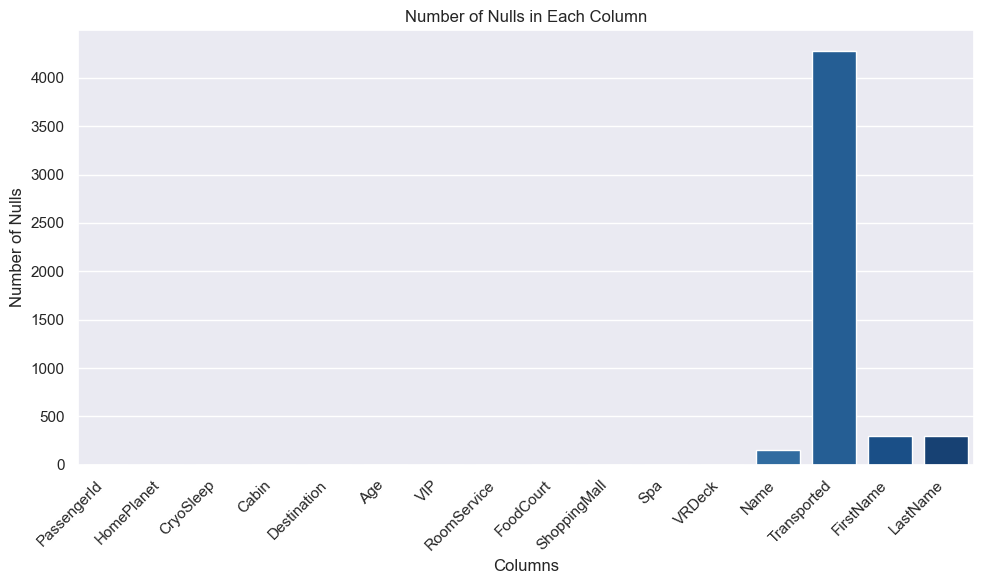

In [140]:
null_updates_in_dataframe(dfErnest)

### Split the combined data back into train and test data

- Each cleaned data will have a different split

In [142]:
train_dfAidan, test_dfAidan = separate_df(dfAidan, len(train_df), len(test_df))
train_dfErnest, test_dfErnest = separate_df(dfErnest, len(train_df), len(test_df))


### Splitting the training data into 2 thirds of training data and 1 third of validation set

In [144]:
def train_data_split(df):
    X = df.drop('Transported', axis=1)  # Features
    y = df['Transported'] 

    # Split the data into training and testing sets (2/3 % train, 1/3 % test)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/3, random_state=42)
    return X_train, X_test, y_train, y_test

#For Aidan
X_train, X_validation, y_train, y_validation = train_data_split(train_dfAidan)
X_train.shape,y_train.shape, X_validation.shape, y_validation.shape

#For Ernest
X_train1, X_validation1, y_train1, y_validation1 = train_data_split(train_dfErnest)
X_train1.shape,y_train1.shape, X_validation1.shape, y_validation1.shape

((5795, 15), (5795,), (2898, 15), (2898,))